In [34]:
# Uncomment first line to write changes to the package
import numpy as np
from sklearn.cluster import KMeans
import scipy

In [97]:
## Terminology is consistent with paper 
# Paper name: Nonstationary Gaussian Process Regression Using Point Estimates of Local Smoothness

class LLS:
  def __init__(self, N=1, input_dim=1): # N = Number of local points
    self.N = N
    self.name = 'LLS'
    self.input_dim = input_dim

  def rbf(self, x1, x2, sigma_l_bar): # RBF for GP_l without variance or noise
    return np.exp(-(x1-x2.T)**2/(2*(sigma_l_bar**2)))
  """
  # Deprecated
  def K_XX(self, x1, x2, sigma_f, sigma_n, l): # From Eq. 7 
    p = l.T@l
    P_r = p
    P_c = p.T
    P_s = P_r + P_c
    E = np.exp(-((x1-x2.T)**2) / P_s)

    return (sigma_f**2)*(0.5**-0.5)*(P_r**0.25)*(P_c**0.25)*(P_s**-0.5)*E  # Eq. 7
  """
  def K(self, x1, x2, sigma_f, sigma_l_bar, l_bar, d): # Main kernel function by Generalizing Eq. 7
    # Calculations for GP_l
    
    K_X_barX_bar = self.rbf(self.X_bar[:,d:d+1], self.X_bar[:,d:d+1], sigma_l_bar[d]) # shape of (X_bar, X_bar)
    
    K_XX_bar1 = self.rbf(x1[:,d:d+1], self.X_bar[:,d:d+1], sigma_l_bar[d]) # shape of (X, X_bar)
    K_XX_bar2 = self.rbf(x2[:,d:d+1], self.X_bar[:,d:d+1], sigma_l_bar[d]) # shape of (X, X_bar)

    # exponent of predictive mean of lengthscales for entire X
    lx1 = np.exp(K_XX_bar1@np.linalg.pinv(K_X_barX_bar)@np.log(l_bar[:,d:d+1])) # shape of (X, X_bar)@(X_bar, X_bar)@(X_bar, 1) = (X, 1)
    lx2 = np.exp(K_XX_bar2@np.linalg.pinv(K_X_barX_bar)@np.log(l_bar[:,d:d+1]))
    P_rc = (lx1@(lx2.T))**2
    P_s = 0.5 * ((lx1**2) + (lx2.T**2))
    E = np.exp(-((x1[:,d:d+1]-x2[:,d:d+1].T)**2) / P_s)
    print('l_bar', l_bar)
    print('E',E.min(),'P_s',P_s.min(),'P_rc',P_rc.min(), lx1.min(), lx2.min())
    return (sigma_f**2)*(P_rc**0.25)*(P_s**-0.5)*E
  
  def predict_lengthscales(self, X_hat):
    l_list = []
    for d in range(X_hat.shape[1]):
        K_X_barX_bar = self.rbf(self.X_bar[:,d:d+1], self.X_bar[:,d:d+1], self.sigma_l_bar[d])
        K_XX_bar = self.rbf(X_hat[:,d:d+1], self.X_bar[:,d:d+1], self.sigma_l_bar[d])
        l = np.exp(K_XX_bar@np.linalg.pinv(K_X_barX_bar)@np.log(self.l_bar[:,d:d+1]))
        l_list.append(l)
    return l_list

  def objective(self, params): # From equation 6 in section 4.1
    print('Start')
    sigma_f = params[0]
    sigma_n = params[1]
    l_bar = params[2:2+self.input_dim*N].reshape(-1,self.input_dim)
    print(l_bar)
    sigma_l_bar = params[-self.input_dim:]
    
    # Evaluating global kernel
    K_XX = self.K(self.X, self.X, sigma_f, sigma_l_bar, l_bar, 0)
    for d in range(1, self.X.shape[1]):
        K_XX *= self.K(self.X, self.X, sigma_f, sigma_l_bar, l_bar, d)
        
    K_X_barX_bar = self.K(self.X_bar, self.X_bar, sigma_f,sigma_l_bar, l_bar, 0)
    for d in range(1, self.X.shape[1]):
        K_X_barX_bar *= self.K(self.X_bar, self.X_bar, sigma_f, sigma_l_bar, l_bar, d)
    print(np.linalg.det(K_XX), 'before')
    np.fill_diagonal(K_XX, sigma_n**2)
    print(np.linalg.det(K_XX))
    try:
        L_theta =  self.y.T@np.linalg.pinv(K_XX)@self.y +\
                   np.log(np.linalg.det(K_XX)) +\
                   np.log(np.linalg.det(K_X_barX_bar)) # Eq. 6
    except:
        print(K_XX)
    print('End')
    return L_theta[0,0]

  def fit(self, X, y, sigma_f=1.2, sigma_n=0.000008, n_restarts_optimizer=10):
    assert len(X.shape) == 2, "X must be 2D"
    assert len(y.shape) == 2, "y must be 2D"
    assert y.shape[1] == 1, "y must be of shape (*,1)"

    self.X = X
    self.y = y
    if self.N <= self.X.shape[0]:
      kmeans = KMeans(n_clusters=self.N)
      self.X_bar = kmeans.fit(X).cluster_centers_
    else:
      self.X_bar = X

    sigma_l_bar = [1.+i*0.01 for i in range(self.input_dim)]
    # Fitting
    optim_fun = np.inf
    for cycle in range(n_restarts_optimizer):
      # initialize lengthscales for support points
      l_bar = np.abs(np.random.rand(self.N, self.input_dim))
      try:
        t_params = [sigma_f]+[sigma_n]+l_bar.ravel().tolist()+sigma_l_bar
        print(t_params)
        res = scipy.optimize.minimize(self.objective, t_params, bounds=[(0.1,10) for _ in range(len(t_params))])
#       except np.linalg.LinAlgError:
#         print('cycle',cycle,'did not converge')
#         continue
      except ValueError:
        print('cycle',cycle,'did not converge')
        continue
      # print(res.fun, 'optim value in cycle', cycle)
      if res.fun==-np.inf:
        print('Infinite cost')
        continue
      if res.fun<optim_fun:
        optim_fun = res.fun
        params = res.x
        self.sigma_f = params[0]
        self.sigma_n = params[1]
        self.l_bar = np.array(params[2:2+self.input_dim*N]).reshape(-1,self.input_dim)
        self.sigma_l_bar = params[-self.input_dim:]
    
    self.params = {'likelihood':optim_fun, 'global variance':self.sigma_f, 'noise_level':self.sigma_n**2, 
                   'N_lengthscales':self.l_bar, 'GP_l_lengthscale':self.sigma_l_bar}
    return self
    
  def get_params(self):
    return self.params

  def predict(self, X_hat, return_cov=False):
    K_XX = self.K(self.X, self.X, self.sigma_f, self.sigma_n, self.sigma_l_bar, self.l_bar, 0)
    for d in range(1, self.X.shape[1]):
        K_XX *= self.K(self.X, self.X, self.sigma_f, self.sigma_n, self.sigma_l_bar, self.l_bar, d)
    np.fill_diagonal(K_XX, self.sigma_n**2)
    K_XX_inv = np.linalg.pinv(K_XX)
    
    K_X_hatX = self.K(X_hat, self.X, self.sigma_f, self.sigma_n, self.sigma_l_bar, self.l_bar, 0)
    for d in range(1, self.X.shape[1]):
        K_X_hatX *= self.K(X_hat, self.X, self.sigma_f, self.sigma_n, self.sigma_l_bar, self.l_bar, d)
    
    K_X_hatX_hat = self.K(X_hat, X_hat, self.sigma_f, self.sigma_n, self.sigma_l_bar, self.l_bar, 0)
    for d in range(1, self.X.shape[1]):
        K_X_hatX_hat *= self.K(X_hat, X_hat, self.sigma_f, self.sigma_n, self.sigma_l_bar, self.l_bar, d)
    
    mean = K_X_hatX@K_XX_inv@self.y
    if return_cov:
      cov = K_X_hatX_hat - K_X_hatX@K_XX_inv@K_X_hatX.T
      return mean, cov
    return mean

## Step function (1d test)

shape of train_X= (20, 1) shape of train_y= (20, 1)


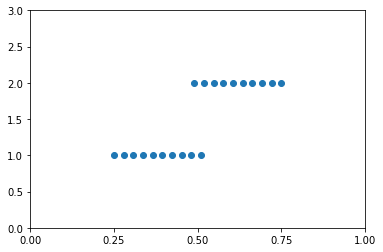

In [98]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
train_X = np.concatenate([np.linspace(0.25,0.51,10), np.linspace(0.49,0.75,10)]).reshape(-1,1)
train_y = np.concatenate([np.ones((10, 1)), np.ones((10, 1))*2])
test_X = np.linspace(0,1,120).reshape(-1,1)
print("shape of train_X=",train_X.shape, "shape of train_y=",train_y.shape)
plt.scatter(train_X, train_y)
plt.ylim(0,3);plt.xticks([0,0.25,0.5,0.75,1]);

[1.2, 8e-06, 0.05450151423333538, 1.0]
Start
[[0.1]]
l_bar [[0.1]]
E 3.2397891784383535e-32 P_s 0.01010863672705547 P_rc 0.00010218453647957474 0.1005417163522459 0.1005417163522459
l_bar [[0.1]]
E 1.0 P_s 0.010000000000000004 P_rc 0.00010000000000000007 0.10000000000000002 0.10000000000000002
0.025525379534088087 before
8.509916368375036e-07
End
Start
[[0.1]]
l_bar [[0.1]]
E 3.2397891784383535e-32 P_s 0.01010863672705547 P_rc 0.00010218453647957474 0.1005417163522459 0.1005417163522459
l_bar [[0.1]]
E 1.0 P_s 0.010000000000000004 P_rc 0.00010000000000000007 0.10000000000000002 0.10000000000000002
0.02552538804254944 before
8.509919602550444e-07
End
Start
[[0.1]]
l_bar [[0.1]]
E 3.2397891784383535e-32 P_s 0.01010863672705547 P_rc 0.00010218453647957474 0.1005417163522459 0.1005417163522459
l_bar [[0.1]]
E 1.0 P_s 0.010000000000000004 P_rc 0.00010000000000000007 0.10000000000000002 0.10000000000000002
0.025525379534088087 before
8.509911597943476e-07
End
Start
[[0.10000001]]
l_bar [[0.1

E nan P_s nan P_rc nan nan nan
nan before
nan
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan nan n

/home/patel_zeel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in log
/home/patel_zeel/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


UnboundLocalError: local variable 'L_theta' referenced before assignment

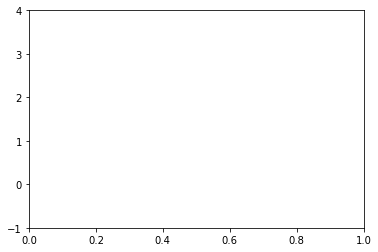

In [99]:
def fit_predict_plot(title):
    plt.figure()
    plt.ylim(-1,4)
    scaler = StandardScaler()
    train_XX = scaler.fit_transform(train_X)
    test_XX = scaler.transform(test_X)
    model.fit(train_XX, train_y)
    pred_y, pred_cov = model.predict(test_XX, return_cov=True)
    pred_std = (pred_cov.diagonal()**0.5*2).squeeze()
    print(pred_std.shape)
    plt.scatter(train_XX, train_y, label='train data')
    plt.plot(test_XX, pred_y, label='predictive mean')
    plt.fill_between(test_XX.squeeze(), pred_y.squeeze()-pred_std, pred_y.squeeze()+pred_std, alpha=0.1)
#     plt.title(title+' likelihood='+str(model.params['likelihood (mll)']))
    plt.vlines(model.X_bar, min(pred_y.squeeze()-pred_std), max(pred_y.squeeze()+pred_std), color='r')
    plt.legend()
#     plt.figure()
#     pred_l = model.predict_lengthscales_(test_XX)
#     plt.plot(test_XX, pred_l, label='lengthscales')
#     plt.vlines(model.X_bar, pred_l.min(), pred_l.max(), color='r')
#     print(model.get_params())
#     plt.legend()

for N in [1,2,3,4,5,6]:
    model = LLS(N=N, input_dim=1)
    fit_predict_plot('LLS Kernel fit: N='+str(N))

# y = log(x1) = exp(x2) (2d test)

shape of train_X= (20, 2) shape of train_y= (20, 1)


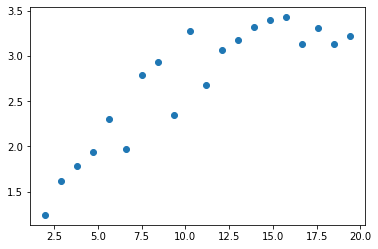

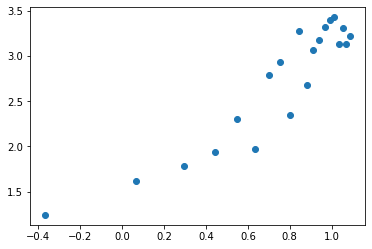

In [19]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
test_X1 = np.linspace(2,20,60).reshape(-1,1)
np.random.seed(0)
test_y = np.log(test_X1)
test_X2 = np.log(test_y)
test_y = test_y+np.random.rand(*test_X1.shape)
test_X = np.concatenate([test_X1, test_X2], axis=1)
train_X = test_X[::3]
train_y = test_y[::3]
print("shape of train_X=",train_X.shape, "shape of train_y=",train_y.shape)
plt.scatter(train_X[:,0], train_y);plt.figure();plt.scatter(train_X[:,1], train_y);

{'likelihood (mll)': -13.817673694698824, 'GP_variance (sigma_f)': array([3.30034609]), 'GP_noise_level (sigma_n)': array([0.10406309]), 'L_GP_variance (sigma_f_bar)': array([1., 1.]), 'L_GP_lengthscale (sigma_l_bar)': array([378.89319802, 479.89306907]), 'L_GP_noise_level (sigma_n_bar)': array([2.99277382e-05, 7.44473548e-05]), 'N_lengthscales (l_bar)': array([[553.45431487, 471.30202105],
       [105.02153   ,  54.16639199]])}


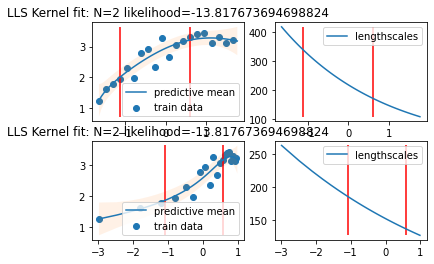

In [22]:
def fit_predict_plot(title):
    scaler = StandardScaler()
    train_XX = scaler.fit_transform(train_X)
    test_XX = scaler.transform(test_X)
    model.fit(train_XX, train_y)
    pred_y, pred_cov = model.predict(test_XX, return_cov=True, diag=False)
    pred_std = (pred_cov.diagonal()**0.5*2).squeeze()
    pred_l = model.predict_lengthscales_(test_XX)
    fig, ax = plt.subplots(2,2)
    for fig_n in [0,1]:
        ax[fig_n,0].scatter(train_XX[:,fig_n], train_y, label='train data')
        ax[fig_n,0].plot(test_XX[:,fig_n], pred_y, label='predictive mean')
        ax[fig_n,0].fill_between(test_XX[:,fig_n].squeeze(), pred_y.squeeze()-pred_std, pred_y.squeeze()+pred_std, alpha=0.1)
        ax[fig_n,0].set_title(title+' likelihood='+str(model.params['likelihood (mll)']))
        ax[fig_n,0].vlines(model.X_bar[:,fig_n], min(pred_y.squeeze()-pred_std), max(pred_y.squeeze()+pred_std), color='r')
        ax[fig_n,0].legend()
        ax[fig_n,1].plot(test_XX[:,fig_n], pred_l[:,fig_n], label='lengthscales')
        ax[fig_n,1].vlines(model.X_bar[:,fig_n], pred_l[:,fig_n].min(), pred_l[:,fig_n].max(), color='r')
        ax[fig_n,1].legend()
    print(model.get_params())

for N in [2]:
    model = LLS(2, N_l_bar=N, optimizer='scipy', kernel='rbf', bounds=(10**-5, 10**5))
    fit_predict_plot('LLS Kernel fit: N='+str(N))

# Benchmarking

### Which Methods are empirically fast??

## Vectorize or not?

In [7]:
from scipy.spatial.distance import cdist
x=np.random.rand(100,10)
y=np.random.rand(100,10)
ps = np.random.rand(100,100,10)

def m1():
    return (np.square(x[:, np.newaxis, :] - y[np.newaxis, :, :])/ps).sum(axis=2)

def m2():
    s = 0
    for i in range(x.shape[1]):
        s += (cdist(x[:,i:i+1], y[:,i:i+1], metric='sqeuclidean')/ps[:,:,i])
    return s

print(np.allclose(m1(), m2()))
%timeit m1()
%timeit m2()

True
498 µs ± 7.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
707 µs ± 1.67 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Cholesky calulations

In [8]:
a = np.random.rand(1000,1000)
a = a@a.T
b = np.abs(np.random.rand(100,1000))

y = np.random.rand(1000, 1)
def original():
    return b@np.linalg.inv(a)@y

def m1():
    L = np.linalg.cholesky(a)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    return b@alpha

def m2():
    L = np.linalg.cholesky(a)
    alpha = scipy.linalg.cho_solve((L, True), y)
    return b@alpha

def m3():
    L = scipy.linalg.cholesky(a, lower=True)
    alpha = scipy.linalg.cho_solve((L, True), y)
    return b@alpha
    

print(np.allclose(original(), m1()), 
      np.allclose(original(), m2()), 
      np.allclose(original(), m3()))
%timeit original()
%timeit m1()
%timeit m2()
%timeit m3()

True True True
356 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
703 ms ± 3.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
34.9 ms ± 87.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.5 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## np.sqrt v/s np.power

In [9]:
l1 = np.random.rand(1000, 1)
l2 = np.random.rand(1000, 1)

aaa = l1@l1.T
%timeit np.sqrt(np.sqrt(aaa))
%timeit np.power(aaa,0.25)
%timeit aaa ** 0.25

2.19 ms ± 4.34 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
59.3 ms ± 81.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
59.3 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## (First @ or *) or vectorize ??

In [10]:
l1 = np.random.rand(70, 3)
l2 = np.random.rand(70, 3)

def m1():
    m = 1
    for i in range(l1.shape[1]):
        m *= l1[:,i:i+1]@l2[:,i:i+1].T
    return m

def m2():
    ll1 =1;ll2=1
    for i in range(l1.shape[1]):
        ll1 *= l1[:,i:i+1]
        ll2 *= l2[:,i:i+1]
    return ll1@ll2.T

def m3():
    return l1.prod(axis=1)[:,np.newaxis]@l2.prod(axis=1)[np.newaxis,:]

print(np.allclose(m1(), m2()), np.allclose(m1(), m3()))

%timeit m1()
%timeit m2()
%timeit m3()

True True
48.9 µs ± 63.5 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
23.4 µs ± 56.7 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
19.4 µs ± 26.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## How to add noise variance to diagonal ?

In [11]:
kk = np.random.rand(200,200)
kk = kk@kk.T

def m1(kk):
    return kk + np.eye(kk.shape[0])*20
    
def m2(kk):
    np.fill_diagonal(kk, kk.diagonal() + 20)
    return kk

def m3(kk):
    kk.ravel()[::kk.shape[1]+1] += 20
    return kk

print(np.allclose(m1(kk), m2(kk)), np.allclose(m1(kk), m3(kk)))

%timeit m1(kk)
%timeit m2(kk)
%timeit m3(kk)

True True
44.9 µs ± 532 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
4.35 µs ± 17.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.93 µs ± 20.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Appendix

In [42]:
from GPy.models import GPRegression
from NSGPy.NumPy import LLS
from GPy.kern import RBF
import matplotlib.pyplot as plt
import numpy as np

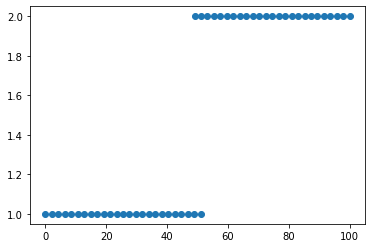

In [43]:
NN = 50
X = np.concatenate([np.linspace(0,51,NN//2), np.linspace(49,100,NN//2)]).reshape(-1,1)
# y = np.cos(X) + np.random.rand(NN,1)*1.2
y = np.concatenate([np.ones((25,1)), np.ones((25,1))*2])
plt.scatter(X, y)

GP_regression.,value,constraints,priors
sum.rbf.variance,2.6089102650407785,+ve,
sum.rbf.lengthscale,144.56246824952416,+ve,
sum.rbf_1.variance,0.07308526061990699,+ve,
sum.rbf_1.lengthscale,11.412784781958944,+ve,
Gaussian_noise.variance,0.02971139286654325,+ve,


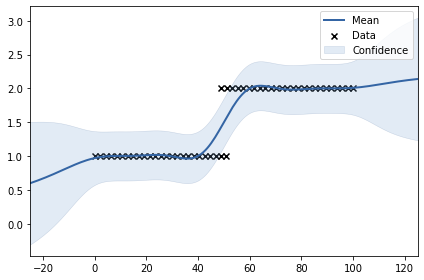

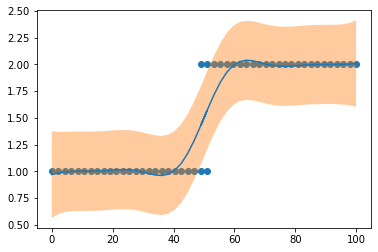

In [44]:
gp_model = GPRegression(X, y, RBF(1, lengthscale=10)+RBF(1, lengthscale=2))
gp_model.optimize()
gp_model.plot()
m, c = gp_model.predict(X)
s2 = (np.sqrt(c)*2).squeeze()
plt.figure()
plt.scatter(X, y);plt.plot(X, m);plt.fill_between(X.squeeze(), m.squeeze()-s2, m.squeeze()+s2, alpha=0.4)
gp_model

{'likelihood (mll)': -75.18088509696537,
 'GP_variance (sigma_f)': array([1.e-05]),
 'GP_linear_variance (sigma_f_lin)': array([0.02082177]),
 'GP_linear_bias (sigma_b_lin)': array([1.08701738]),
 'GP_noise_level (sigma_n)': array([0.14640748]),
 'L_GP_variance (sigma_f_bar)': array([1.e-05]),
 'L_GP_lengthscale (sigma_l_bar)': array([0.2160895]),
 'L_GP_noise_level (sigma_n_bar)': array([1.e-05]),
 'N_lengthscales (l_bar)': array([[0.00623026],
        [0.25298236],
        [0.43479153],
        [0.78077448],
        [0.19783677],
        [0.8640215 ],
        [0.98340068],
        [0.16404987],
        [0.59733394],
        [0.0089861 ]])}

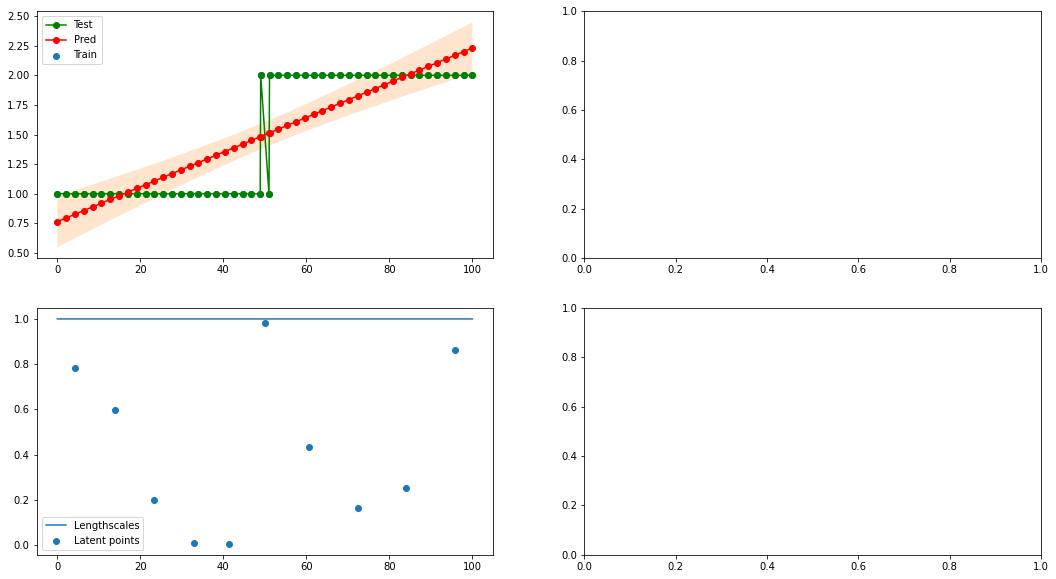

In [45]:
nsgp_model = LLS(1, N_l_bar=10, seed=0)
nsgp_model.fit(X, y)
fig, ax = plt.subplots(2,2,figsize=(18,10))
nsgp_model.predict_plot(ax, X, y)
nsgp_model.get_params()

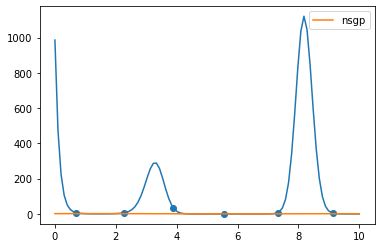

In [5]:
def func(x1, x2):
    return np.exp(-np.square(x1-x2.T)/(nsgp_model.get_params()['L_GP_lengthscale (sigma_l_bar)'][0])**2)
plt.scatter(nsgp_model.X_bar, nsgp_model.l_bar)
plt.plot(X, np.exp(func(X, nsgp_model.X_bar)@np.linalg.pinv(func(nsgp_model.X_bar, nsgp_model.X_bar))@np.log(nsgp_model.l_bar)));
plt.plot(X, nsgp_model.predict_lengthscales_(X), label='nsgp');plt.legend();

In [6]:
nsgp_model.K_bar(np.array(1), nsgp_model.sigma_l_bar, X)[:3,:3].squeeze()

array([[1.        , 0.99875902, 0.99504531],
       [0.99875902, 1.        , 0.99875902],
       [0.99504531, 0.99875902, 1.        ]])

In [7]:
func(X, X)[:3,:3]

array([[1.        , 0.99875902, 0.99504531],
       [0.99875902, 1.        , 0.99875902],
       [0.99504531, 0.99875902, 1.        ]])

In [8]:
np.exp(-np.square(X[:,np.newaxis,:] - X[np.newaxis,:,:])/nsgp_model.sigma_l_bar.reshape(1,1,1))[:3,:3]

array([[[1.        ],
        [0.99644688],
        [0.9858631 ]],

       [[0.99644688],
        [1.        ],
        [0.99644688]],

       [[0.9858631 ],
        [0.99644688],
        [1.        ]]])